In [1]:
#Python Language Version 

from platform import python_version
print('Versão da Linguagem Python Usada neste projeto:', python_version())

Versão da Linguagem Python Usada neste projeto: 3.8.5


# Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python

### Projeto - Qual o Efeito da Legalização da Maconha na Taxa de Criminalidade ao Longo do Tempo?

![Rodolfo Terra](https://raw.githubusercontent.com/rodolffoterra/Projct_Marijuana_Legalization_TS/main/imagnes/layout4.png)

### Definição do Problema

Em 2016, os eleitores da Califórnia nos EUA aprovaram a Proposição 64, que legalizou o uso recreativo da maconha no estado. Neste link você encontra os detalhes sobre a aprovação da Proposição 64:

<a href="https://ballotpedia.org/California_Proposition_64,_Marijuana_Legalization_(2016)">California Proposition 64, Marijuana Legalization (2016)</a>

Os opositores à medida apresentaram cinco principais objeções à mudança no Guia Oficial de Informações do Eleitor do estado. Eles argumentaram que a legalização:

- (1) Dobraria o número de mortes nas rodovias.
- (2) Permitiria o cultivo de maconha perto de escolas e parques.
- (3) Aumentaria a atividade do mercado negro e do cartel.
- (4) Prejudicaria as comunidades pobres com problemas de dependência por meio do influxo de novos pontos de vendas de maconha.
- (5) Aumentaria a criminalidade ao longo do tempo, especialmente nas áreas próximas aos pontos de venda de maconha legalizada (cada ponto de venda de maconha legalizada é chamado de marijuana dispensary). 

Vamos realizar uma análise de dados com base em séries temporais e análises geoespaciais, além de outras técnicas exploratórias mais gerais, para examinar se essas previsões se tornaram realidade em Los Angeles desde que a legalização entrou em vigor. Nosso foco principal será nos dados disponíveis sobre detenções por crimes relacionados à maconha e na taxa geral de crimes nas proximidades de dispensários. Vamos focar principalmente nos itens 2, 4 e 5 acima.

Os dados usados neste projeto estão disponíveis publicamente e são oferecidos pelo portal de dados abertos do governo de Los Angeles.

Você é favor ou contra a legalização da Maconha? Acompanhe o projeto passo a passo, leia atentamente cada comentário e então emita sua opinião com base em dados.

# Sumário:

- Série Temporal das Prisões
- Série Temporal das Escolhas

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# The new versions of Pandas and Matplotlib bring several warning messages to the developer.; Let's disable this
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports for data Manipulation 
import scipy
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from scipy import stats

# Import for bformatting graphics

m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
plt.style.use('fivethirtyeight')
%matplotlib inline

In [5]:
# # Loading prison data
df_prisoes = pd.read_csv('dados/df_prisoes_parte2.csv')

In [6]:
# Shape
df_prisoes.shape

(6226, 14)

In [7]:
# We preview a sample of data
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,3,13,4,8
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4


In [9]:
# We group by date
df_prisoes_g = df_prisoes.groupby('Arrest Date').sum()

In [10]:
# Total prisons near schools within 1 mile
df_prisoes_g['escola_1_milha'].head()

Arrest Date
2014-01-01    39
2014-01-02    48
2014-01-03    10
2014-01-04    32
2014-01-05    20
Name: escola_1_milha, dtype: int64

In [11]:
# Total arrests near schools up to 0.5 miles aways
df_prisoes_g['escola_0.5_milha'].head()

Arrest Date
2014-01-01    14
2014-01-02    15
2014-01-03     1
2014-01-04     8
2014-01-05     6
Name: escola_0.5_milha, dtype: int64

In [34]:
# Let's save to dataframes
df_prisoes_uma_milha_escolas = pd.DataFrame(df_prisoes_g['escola_1_milha'])
df_prisoes_meia_milha_escolas = pd.DataFrame(df_prisoes_g['escola_0.5_milha'])

In [35]:
# Data
df_prisoes_uma_milha_escolas.head(3)

,escola_1_milha
Arrest Date,
2014-01-01,39
2014-01-02,48
2014-01-03,10


In [36]:
# Data
df_prisoes_meia_milha_escolas.head(3)

,escola_0.5_milha
Arrest Date,
2014-01-01,14
2014-01-02,15
2014-01-03,1


O índice do dataframe é do tipo Index, mas para poder calcular o total por mês, precisamos transformar para o tipo DateTimeIndex.

In [37]:
# The Dataframe index is of type Index
df_prisoes_uma_milha_escolas.index

Index(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
       '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
       ...
       '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
       '2019-12-20', '2019-12-22', '2019-12-26', '2019-12-28', '2019-12-29'],
      dtype='object', name='Arrest Date', length=1691)

In [38]:
# We need to adjust the index to group the series with monthly totals
df_prisoes_uma_milha_escolas.index = pd.to_datetime(df_prisoes_uma_milha_escolas.index)
df_prisoes_meia_milha_escolas.index = pd.to_datetime(df_prisoes_meia_milha_escolas.index)

In [39]:
# Type changed
df_prisoes_uma_milha_escolas.index
df_prisoes_meia_milha_escolas.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-22', '2019-12-26',
               '2019-12-28', '2019-12-29'],
              dtype='datetime64[ns]', name='Arrest Date', length=1691, freq=None)

In [40]:
# We need to adjust the index to group the series with monthly totals
df_prisoes_uma_milha_escolas.index = pd.to_datetime(df_prisoes_uma_milha_escolas.index)
df_prisoes_meia_milha_escolas.index = pd.to_datetime(df_prisoes_meia_milha_escolas.index)

Podemos então aplicar o resample e calcular o total por mês.

In [41]:
# Total per Month
df_prisoes_uma_milha_escolas.resample('M').sum().head()

,escola_1_milha
Arrest Date,
2014-01-31,1335
2014-02-28,1107
2014-03-31,1245
2014-04-30,902
2014-05-31,1128


In [42]:
# Total per Month
df_prisoes_meia_milha_escolas.resample('M').sum().head()

,escola_0.5_milha
Arrest Date,
2014-01-31,383
2014-02-28,308
2014-03-31,333
2014-04-30,259
2014-05-31,269


**Qual terá sido o padrão das prisões com escolas até 1 milha de distância?**

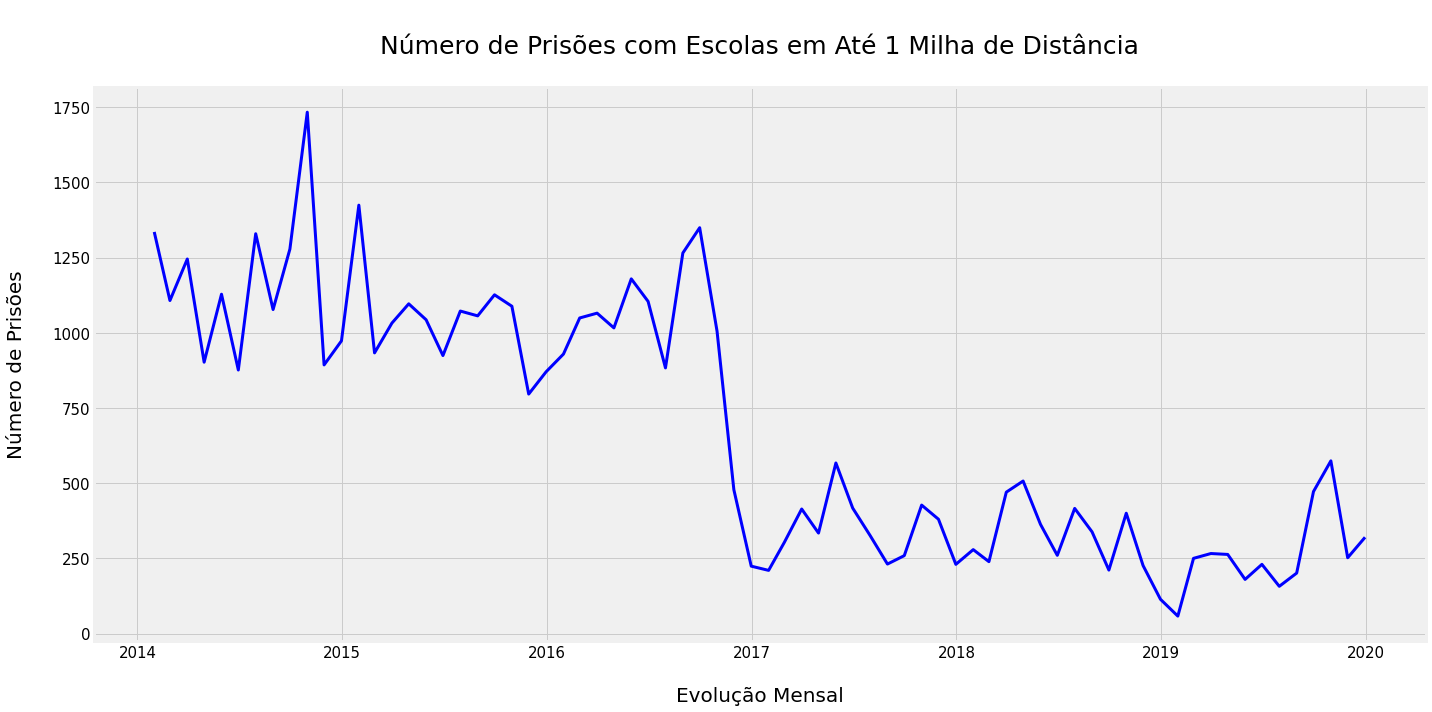

In [43]:
# Plot

# Figure
plt.figure(figsize = (20,10))

# Plot of data
plt.plot(df_prisoes_uma_milha_escolas.resample('M').sum(), color = 'blue', linewidth = 3)

# Labels and captions
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("\nNúmero de Prisões com Escolas em Até 1 Milha de Distância\n", fontsize = 25)
plt.xlabel('\nEvolução Mensal', fontsize = 20)
plt.ylabel('Número de Prisões\n', fontsize = 20)
plt.tight_layout()

Alguma coisa aconteceu em 2017. O que foi? A legalização da maconha. Não podemos afirmar categoricamente ainda, mas tudo leva a crer que a legalização da maconha contribuiu para a redução das prisões. Mas os crimes foram reduzidos mesmo ou apenas mudaram a forma de contabilizar (o que antes era crime, deixou de ser)? Criaremos um modelo para estudar isso na Parte 5.

**Qual terá sido o padrão das prisões com escolas até 0.5 milha de distância?**

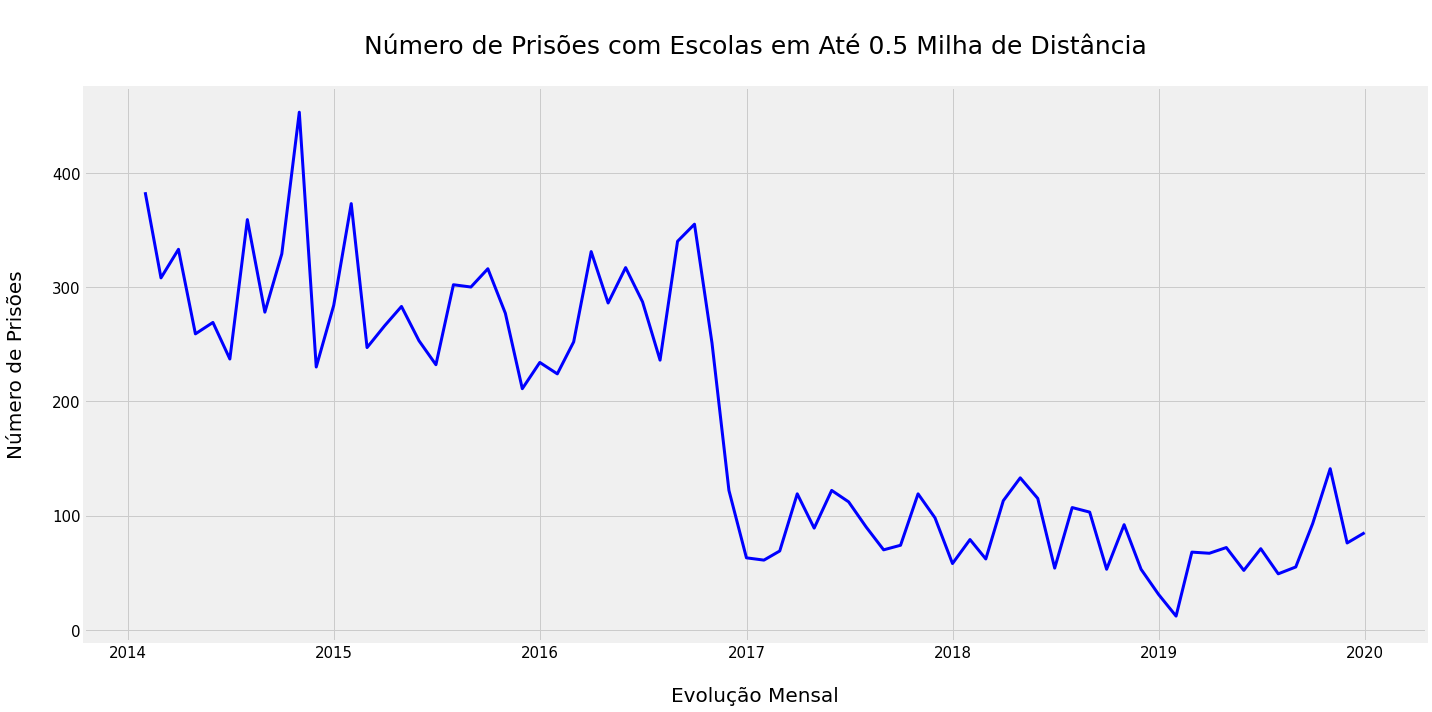

In [44]:
# Plot

# Figure
plt.figure(figsize = (20,10))

# Plot of data
plt.plot(df_prisoes_meia_milha_escolas.resample('M').sum(), color = 'blue', linewidth = 3)

# Labels and captions
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('\nNúmero de Prisões com Escolas em Até 0.5 Milha de Distância\n', fontsize = 25)
plt.xlabel('\nEvolução Mensal', fontsize = 20)
plt.ylabel('Número de Prisões\n', fontsize = 20)
plt.tight_layout()

Exatamente o mesmo padrão!

### Qual Crime Levou ao Maior Número de Prisões?

Vamos investigar qual foi o principal crime e o total de prisões por ano. 

In [49]:
# We created dataframes with records for the years 2014 to 2019
df_prisoes_2014 = df_prisoes[(df_prisoes['Arrest Date'] < '2015-01-01') & (df_prisoes['Arrest Date'] >= '2014-01-01')]
df_prisoes_2015 = df_prisoes[(df_prisoes['Arrest Date'] < '2016-01-01') & (df_prisoes['Arrest Date'] >= '2015-01-01')]
df_prisoes_2016 = df_prisoes[(df_prisoes['Arrest Date'] < '2017-01-01') & (df_prisoes['Arrest Date'] >= '2016-01-01')]
df_prisoes_2017 = df_prisoes[(df_prisoes['Arrest Date'] < '2018-01-01') & (df_prisoes['Arrest Date'] >= '2017-01-01')]
df_prisoes_2018 = df_prisoes[(df_prisoes['Arrest Date'] < '2019-01-01') & (df_prisoes['Arrest Date'] >= '2018-01-01')]
df_prisoes_2019 = df_prisoes[(df_prisoes['Arrest Date'] < '2020-01-01') & (df_prisoes['Arrest Date'] >= '2019-01-01')]

In [47]:
# Function for graph total arrests by type of crimes
def grafico_total_tipo_crime(dataframe, ano):
    
    # We filter the dataframe by tipe of crime
    # then we count the records for each type
    # we sort in ascending order
    #We created the bar chart
    # All the same line of code
    ax = dataframe['Charge Description'].value_counts(ascending = True).tail().plot(kind = 'bar',
                                                                                   figsize = (16,10),
                                                                                   color = 'green',
                                                                                   fontsize = 12,
                                                                                   alpha = 0.75,
                                                                                   rot = 30);
    ax.set_alpha(0.8)
    ax.set_title(f'\nTotal de Prisões Por Tipo de Crime em {ano}\n', fontsize = 18)
    ax.set_ylabel('\nTipo de Crime\n', fontsize = 18);
    ax.set_xlabel('\nTotal de Crimes\n', fontsize = 18)   

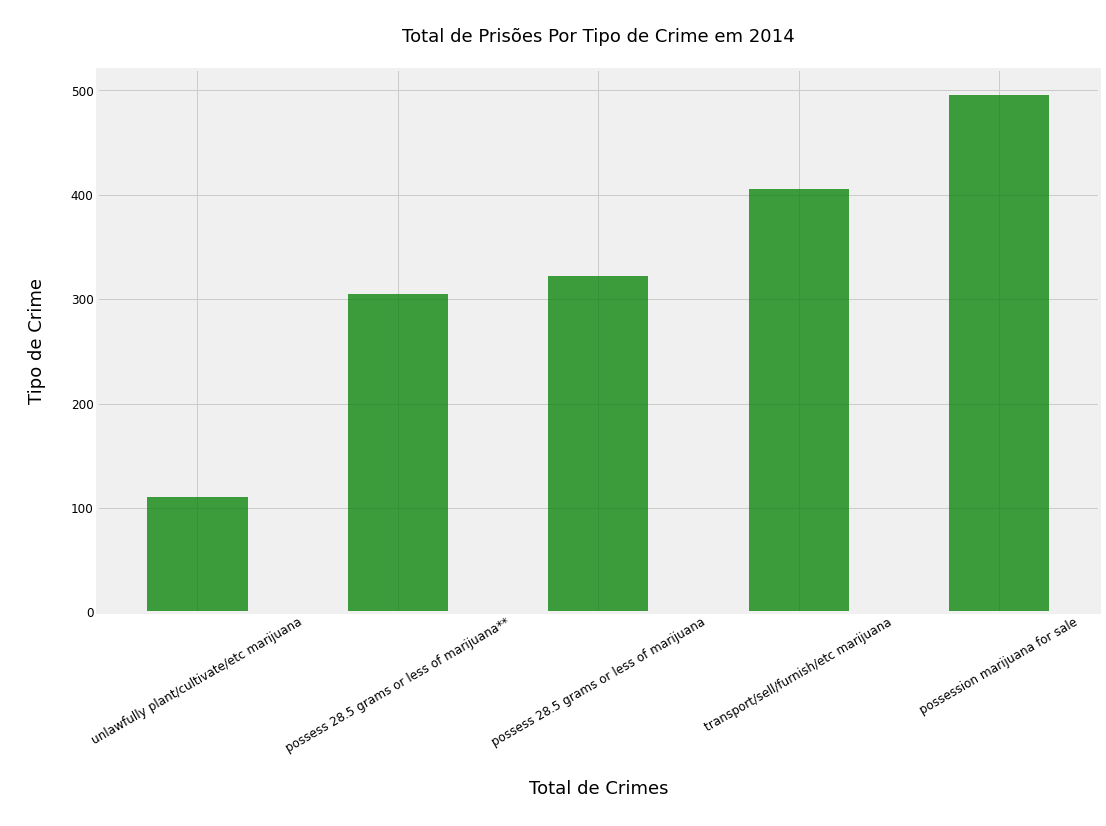

In [50]:
# Graph of Total Arrests by Type of Crime in 2014
grafico_total_tipo_crime(df_prisoes_2014, 2014)

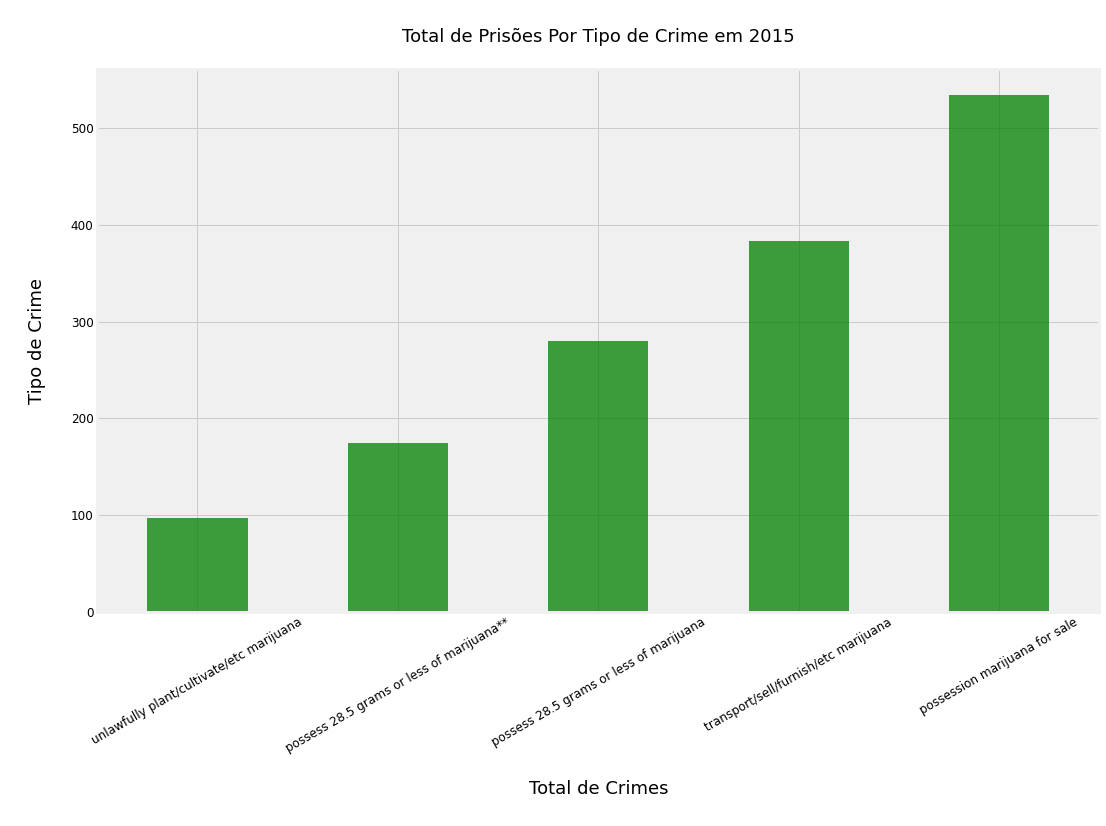

In [51]:
# Graph of Total Arrests by Type of Crime in 2015
grafico_total_tipo_crime(df_prisoes_2015, 2015)

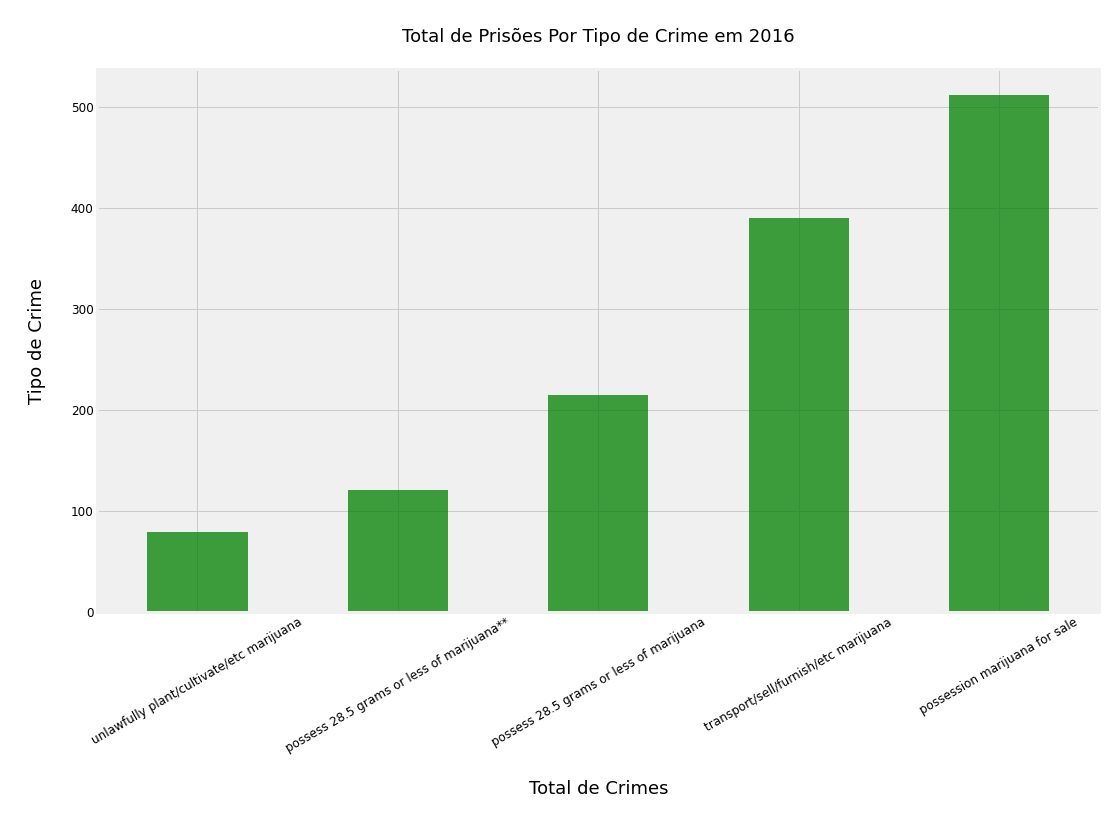

In [52]:
# Graph of Total Arrests by Type of Crime in 2016
grafico_total_tipo_crime(df_prisoes_2016, 2016)

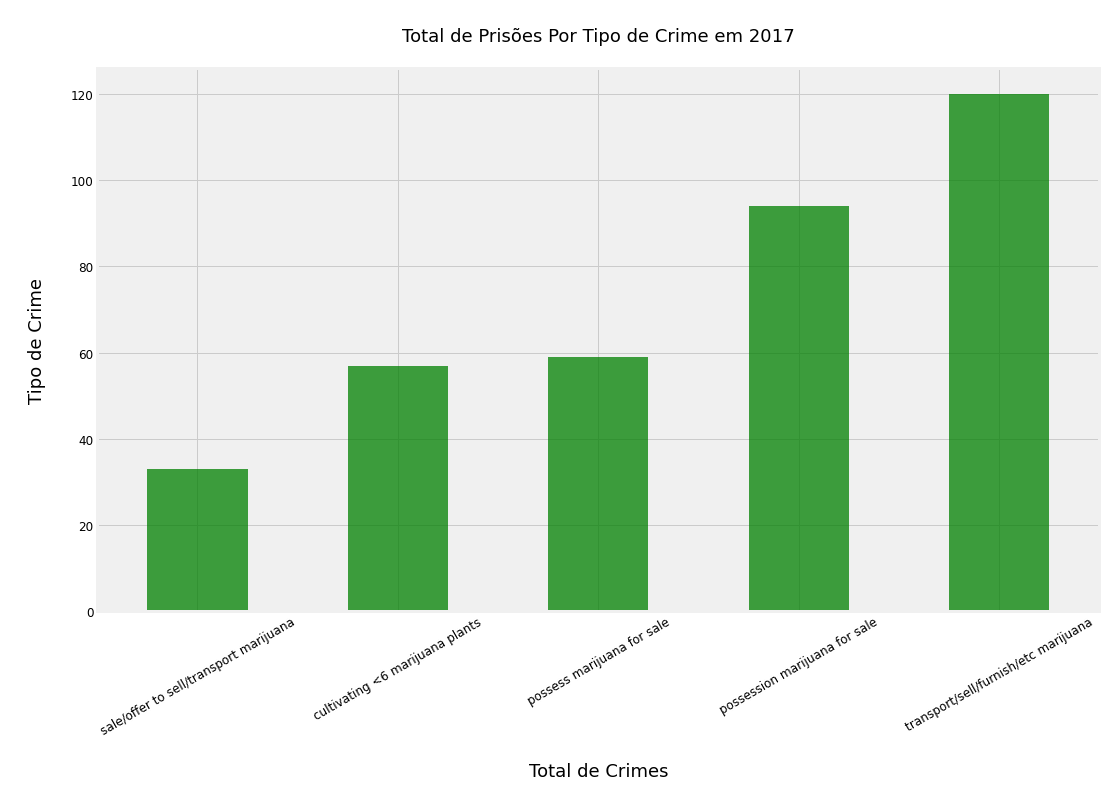

In [53]:
# Graph of Total Arrests by Type of Crime in 2017
grafico_total_tipo_crime(df_prisoes_2017, 2017)

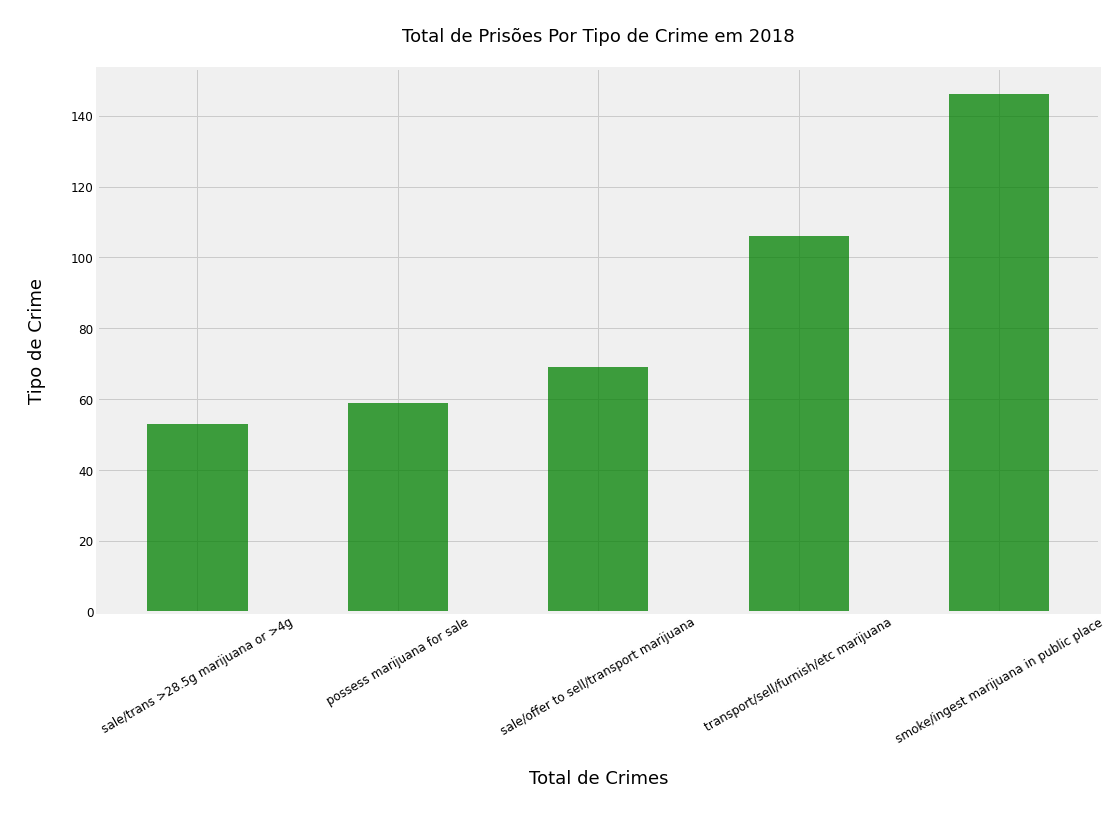

In [54]:
# Graph of Total Arrests by Type of Crime in 2018
grafico_total_tipo_crime(df_prisoes_2018, 2018)

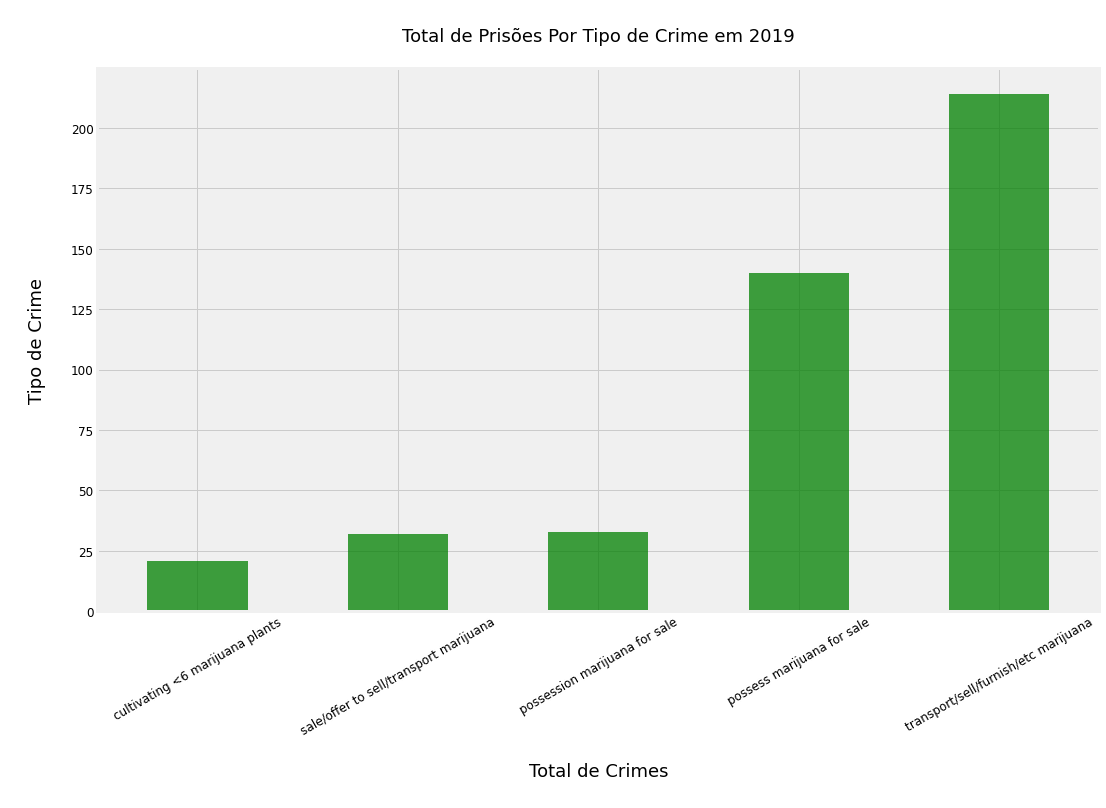

In [55]:
# Graph of Total Arrests by Type of Crime in 2019
grafico_total_tipo_crime(df_prisoes_2019, 2019)

Além da clara redução no número de prisões, tivemos uma alternância no tipo de crime ao longo dos anos. Desde que a legalização da maconha entrou em vigor em 1º de janeiro de 2017, a principal causa de prisões relacionadas à maconha mudou.

### Modelagem Estatística

Vamos agora extrair alguns detalhes estatísticos dos dados e na sequência aplicar um teste de normalidade.

In [57]:
# Data
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,3,13,4,8
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4


In [58]:
# Statistical summary
# The T artribute defines the matrix transpose
df_prisoes.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,6226.0,1510.445551,532.154330,1.0000,1255.0000,1600.0000,1900.00000,2358.0000
Age,6226.0,30.492130,11.340485,12.0000,22.0000,27.0000,36.00000,78.0000
latitude,6226.0,34.060416,0.114515,33.7096,33.9875,34.0477,34.13495,34.3286
longitude,6226.0,-118.357139,0.095218,-118.6574,-118.4335,-118.3337,-118.27830,-118.1624
loja_0.5_milha,6226.0,1.773209,2.674940,0.0000,0.0000,1.0000,2.00000,12.0000
loja_1_milha,6226.0,4.702217,5.450381,0.0000,1.0000,2.0000,7.00000,25.0000
escola_0.5_milha,6226.0,2.087536,1.854347,0.0000,1.0000,2.0000,3.00000,11.0000
escola_1_milha,6226.0,7.874398,5.695285,0.0000,4.0000,7.0000,11.00000,33.0000


In [59]:
# Data Type
df_prisoes.dtypes

Arrest Date            object
Time                  float64
Area Name              object
Age                     int64
Sex Code               object
Descent Code           object
Arrest Type Code       object
Charge Description     object
latitude              float64
longitude             float64
loja_0.5_milha          int64
loja_1_milha            int64
escola_0.5_milha        int64
escola_1_milha          int64
dtype: object

In [60]:
# Data types
df_prisoes.nunique()

Arrest Date           1691
Time                   430
Area Name               21
Age                     66
Sex Code                 2
Descent Code            10
Arrest Type Code         3
Charge Description      32
latitude              1737
longitude             1654
loja_0.5_milha          13
loja_1_milha            26
escola_0.5_milha        12
escola_1_milha          34
dtype: int64

Vamos remover as colunas latitude e longitude, pois para o nosso propósito, análise estatística dessas variáveis não faz muito sentido.

In [61]:
# Remove two variables
df_prisoes_var = df_prisoes.describe().drop(['latitude','longitude'],1).columns

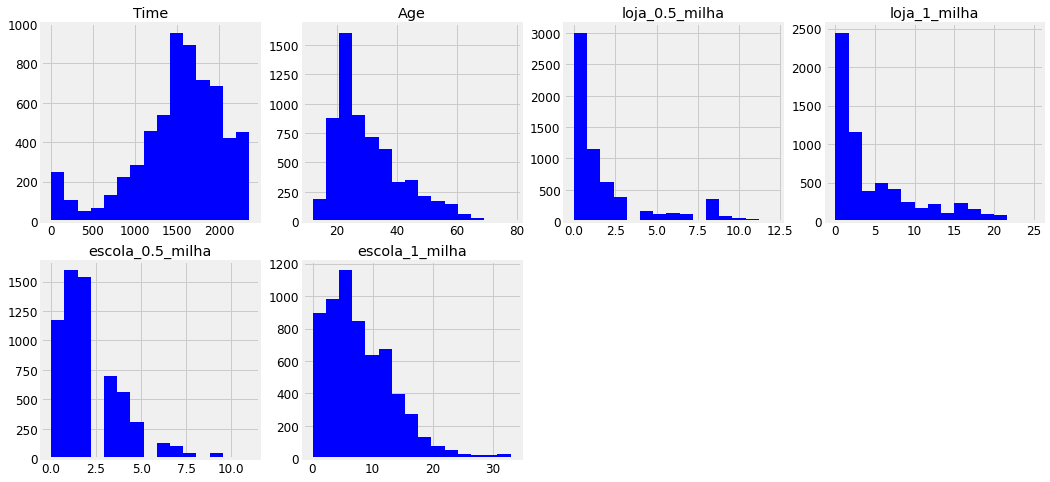

In [63]:
# Histogram

# Figuire
fig = plt.figure(figsize = (16,8))

# Loop throught variables and histogram plot
for i, col in enumerate(df_prisoes_var):
    fig.add_subplot(2, 4, 1+i)
    col_data = df_prisoes[col]
    plt.hist(col_data, bins = 15, color = 'blue')
    plt.title(col)

Parece que nenhuma variável segue uma distribuição normal. Checamos isso daqui a pouco. Vamos conferir o dataframe de escolas.

In [66]:
# # Loading prison data
df_escolas = pd.read_csv('dados/df_escolas_parte2.csv')

In [67]:
# Describe
df_escolas[['prisao_0.5_milha','prisao_1_milha']].describe()

,prisao_0.5_milha,prisao_1_milha
count,914.000000,914.000000
mean,14.219912,53.638950
std,28.074045,68.279071
min,0.000000,0.000000
25%,1.000000,12.000000
50%,7.000000,32.000000
75%,19.000000,73.000000
max,552.000000,677.000000


In [68]:
# Let's create the histogram of theses two variables
df_escolas_var = ['prisao_0.5_milha', 'prisao_1_milha']

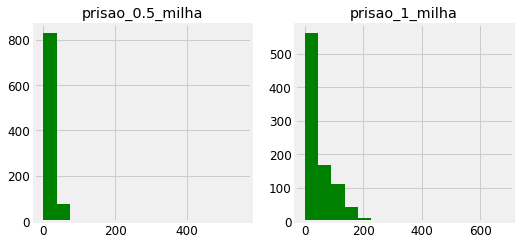

In [70]:
# Histogram

# Figuire
fig = plt.figure(figsize = (16,8))

# Loop throught variables and histogram plot
for i, col in enumerate(df_escolas_var):
    fig.add_subplot(2, 4, 1+i)
    col_data = df_escolas[col]
    plt.hist(col_data, bins = 15, color = 'green')
    plt.title(col)

Parece que nenhuma variável segue uma distribuição normal. Vamos checar então.

### Teste de Normalidade das Variáveis

Muitos algoritmos de Machine Learning fazem suposições sobre os dados. Em geral, consideramos que essas suposições são verdadeiras, mas devemos tomar cuidado com isso, pois se uma suposição estiver sendo violada estaremos extraindo conclusões equivocadas de todo o processo de Ciência de Dados.

E uma das suposições mais comuns é a de normalidade, ou seja, que a variável segue uma distribuição normal. Isso significa que a distribuição de probabilidades da variável (todos os possíveis valores que a variável pode assumir), tem o formato como da imagem abaixo:

![title](imagens/normal.png)

**Distribuição Normal**

Uma distribuição normal (ou gaussiana) é uma distribuição de probabilidade contínua que possui uma função de densidade de probabilidade em forma de sino. É a distribuição de probabilidade mais proeminente em Estatística.

As distribuições normais são uma família de distribuições com a mesma curva geral simétrica em forma de sino, com mais valores concentrados no meio do que nas caudas. Dois parâmetros descrevem uma distribuição normal, a média e o desvio padrão. A média é a localização central (o pico) e o desvio padrão é a dispersão. A assimetria e curtose são zero para uma distribuição normal.

A distribuição normal é a base de muitas teorias estatísticas. Testes estatísticos e estimadores baseados na distribuição normal costumam ser mais poderosos do que seus equivalentes não paramétricos. Quando a suposição de distribuição pode ser atendida, elas são as melhores opções, pois isso permite usar um tamanho de amostra menor para detectar a mesma diferença.

E podemos usar uma das mais úteis ferramentas da Inferência Estatística para testar essa suposição: o Teste de Hipóteses.

**Teste de Hipóteses**

O teste de hipóteses é o processo formal de fazer inferências a partir de uma amostra, se uma afirmação sobre a população parece ou não verdadeira.

Um teste de hipóteses é um método de tomada de decisões. Você deve declarar uma hipótese nula e uma hipótese alternativa para executar um teste de hipóteses. A hipótese nula afirma o que o estudo pretende rejeitar e refutar. A hipótese alternativa é geralmente a negação da hipótese nula e afirma o que o estudo está tentando provar.

Quando as hipóteses são declaradas, um teste estatístico calcula uma estatística e um valor-p. O valor-p é a probabilidade de obter uma estatística de teste pelo menos tão extrema quanto a observada quando a hipótese nula é verdadeira. É uma medida de evidência contra a hipótese nula. Quando o valor-p é pequeno, é improvável que os dados tenham ocorrido se a hipótese nula for verdadeira, para que você possa rejeitar a hipótese nula e aceitar a hipótese alternativa. Quando o valor-p é grande, você não pode rejeitar a hipótese nula; não há evidências suficientes contra isso. 

Não é possível provar a hipótese nula, apenas refutá-la. O valor-p não permite que você faça afirmações sobre a probabilidade da hipótese nula ser verdadeira; é uma declaração baseada na observação dos dados.

Um Teste de Hipóteses testa formalmente se a população que a amostra representa é normalmente distribuída.

A hipótese nula (H0) afirma que a população é normalmente distribuída, contra a hipótese alternativa (H1) de que não é normalmente distribuída. 

Se o valor-p do teste for menor que o nível de significância predefinido, você poderá rejeitar a hipótese nula e concluir que os dados não são de uma população com uma distribuição normal. Se o valor-p for maior que o nível de significância predefinido, você não poderá rejeitar a hipótese nula.

Observe que pequenos desvios da normalidade podem produzir um valor-p estatisticamente significativo quando o tamanho da amostra é grande e, inversamente, pode ser impossível detectar a não normalidade com uma amostra pequena. Você sempre deve examinar o gráfico normal e usar seu julgamento, em vez de confiar apenas no teste de hipóteses. Muitos testes estatísticos e estimadores são robustos contra partidas moderadas na normalidade devido ao teorema central do limite limite central.

Vamos criar uma função e testar a normalidade das variáveis

In [72]:
# Function to test the normality of variable
def testa_normalidade(dataframe, list_of_cols ,sig_level = 0.05):
    
    # List od dataframe columns
    total_variables = len(list_of_cols)
    
    # Initializes the counter of variables that are 'nom-normal'
    not_normal_variables = 0
    
    # Loop on each column in the column list
    for col in list_of_cols:
        
        # Performs the normality test for the variable
        p_val = stats.normaltest(dataframe[col])[1]
        
        # Significance Level
        sig_lvl = 0.05
        
        # Checks the p-valuie
        if p_val < sig_lvl:
            print(f'{col}')
            print(f'Valor-p: {p_val}\nNível de Significância: {sig_lvl}\n')
            print("Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.\n")
            not_normal_variables += 1
        elif p_val > sig_lvl:
            print(f'{col}')
            print(f'Valor-p: {p_val}\nNível de Significância: {sig_lvl}\n')
            print("Como o Valor-p é maior que o Nível de Significância, nós falhamos em rejeitar a hipótese nula.\n")
    
    if not_normal_variables/total_variables == 1:
        print('Para cada variável, como o valor-p é menor que o nível de significância, rejeite a hipótese nula e conclua que a variável não segue a distribuição normal.')
    else:
        print(f'{not_normal_variables} varáveis que não seguem uma distribuição normal')


In [75]:
# Executes the function
testa_normalidade(df_prisoes, df_prisoes_var)

Time
Valor-p: 3.7075045947738646e-165
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.

Age
Valor-p: 1.1205894980358965e-190
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.

loja_0.5_milha
Valor-p: 0.0
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.

loja_1_milha
Valor-p: 6.65383858564841e-253
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.

escola_0.5_milha
Valor-p: 5.0694706410973965e-291
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nu

In [76]:
# Executes the function
testa_normalidade(df_escolas, df_escolas_var)

prisao_0.5_milha
Valor-p: 0.0
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.

prisao_1_milha
Valor-p: 2.89834664499081e-162
Nível de Significância: 0.05

Como o Valor-p é menor que o Nível de Significância, rejeitamos a hipótese nula e concluímos que a variável não segue uma distribuição normal.

Para cada variável, como o valor-p é menor que o nível de significância, rejeite a hipótese nula e conclua que a variável não segue a distribuição normal.


**Conclusão**: Nenhuma variável segue uma distribuição normal, o que significa que devemos ser cautelosos ao criar nossos modelos preditivos na Parte 5.

### Conclusão Final

Claramente parece haver um padrão entre o volume de prisões e a legalização da maconha. A proximidade das prisões com pontos de vendas ou com escolas não parece variar de um ano para o outro, o que leva a crer que pontos de venda ou escolas não estão ligados às prisões. Talvez outro fator explique melhor a redução das prisões. Acho que Machine Learning poderá ajudar nisso. Até a Parte 5.

<a href="https://github.com/rodolffoterra/Projct_Marijuana_Legalization_TS/blob/main/Projct_Marijuana_Legalization_TS_Part3.ipynb">Retornar o Projeto: Parte. 3</a>&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;<a href="https://github.com/rodolffoterra/Projct_Marijuana_Legalization_TS/blob/main/Projct_Marijuana_Legalization_TS_Part5.ipynb">Continuação do Projeto: Parte. 5</a>

![Rodolfo Terra](https://raw.githubusercontent.com/rodolffoterra/Projct_Marijuana_Legalization_TS/main/imagnes/logo.png)